In [31]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [70]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
import pathlib

import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime

In [71]:
os.environ['TF_CPP_MIN_LEVEL'] = '0'
np.set_printoptions(precision=3, suppress=True)
# stops the plt warnings
tf.get_logger().setLevel('ERROR')

In [74]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
dt_save = now.strftime("%d%m%Y")
print("ddmmyyyy =", dt_save)

ddmmyyyy = 07112022


In [34]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    print(testFiles)

['../data/Test/Scab_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple', '../data/Test/Blotch_Apple']
['../data/Test/Scab_Apple', '../data/Test/.DS_Store', '../data/Test/Normal_Apple', '../data/Test/Blotch_Apple', '../data/Test/Rot_Apple']


In [35]:
edgeFiles = [img for img in edgeFiles if ".jpg" in img]
# print(type(edgeFiles))
# print(edgeFiles[0])

In [36]:
batch_size = 32
img_height = 360
img_width = 360

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [39]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [40]:
class_names = train_ds.class_names
test_label = test_ds.class_names

In [41]:
# augmentation toegevoegen
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
  layers.RandomZoom(0.6),  
])

In [42]:
# augmentation toegevoegen
image, label = next(iter(train_ds))

In [43]:
# augmentation toegevoegen
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

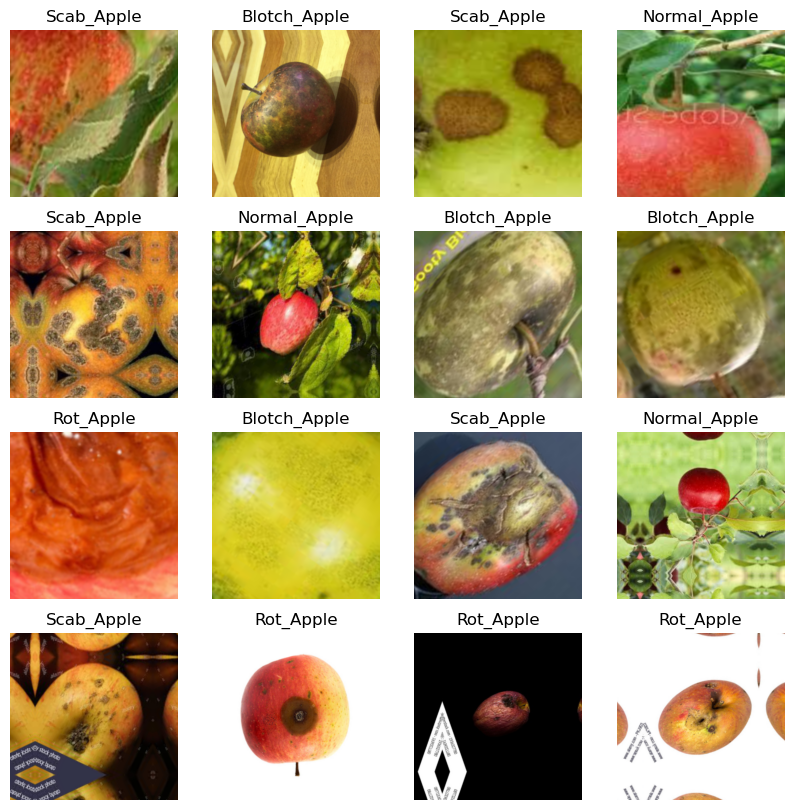

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_image = data_augmentation(images, training = True)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [45]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.2 ),  
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(30, activation='relu'),
  layers.Dense(30, activation='relu'),
  layers.Dense(4, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbackEarly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 360, 360, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 360, 360, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 180, 180, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

In [49]:
epochs=35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback, callbackEarly]
)

Epoch 1/35
10/10 [==============================] - 21s 2s/step - loss: 1.4928 - accuracy: 0.2736 - val_loss: 1.3508 - val_accuracy: 0.2500
Epoch 2/35
10/10 [==============================] - 18s 2s/step - loss: 1.3420 - accuracy: 0.3681 - val_loss: 1.3869 - val_accuracy: 0.2632
Epoch 3/35
10/10 [==============================] - 18s 2s/step - loss: 1.3055 - accuracy: 0.4267 - val_loss: 1.3218 - val_accuracy: 0.3816
Epoch 4/35
10/10 [==============================] - 18s 2s/step - loss: 1.3062 - accuracy: 0.3844 - val_loss: 1.2746 - val_accuracy: 0.5000
Epoch 5/35
10/10 [==============================] - 18s 2s/step - loss: 1.2967 - accuracy: 0.4365 - val_loss: 1.3142 - val_accuracy: 0.2895
Epoch 6/35
10/10 [==============================] - 18s 2s/step - loss: 1.2647 - accuracy: 0.4300 - val_loss: 1.2731 - val_accuracy: 0.4868
Epoch 7/35
10/10 [==============================] - 18s 2s/step - loss: 1.2737 - accuracy: 0.4625 - val_loss: 1.2484 - val_accuracy: 0.4868
Epoch 8/35
10/10 [==

In [50]:
# Tensorboard
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
score = model.evaluate(test_ds)


4/4 [==============================] - 2s 352ms/step - loss: 1.0886 - accuracy: 0.5667


In [58]:
loss, accuracy = model.evaluate(train_ds)

10/10 [==============================] - 4s 357ms/step - loss: 1.0370 - accuracy: 0.6352


In [63]:
# folder path to save figureplot 
sp_model = r'saved_models/tf_tensor/model'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
print('File count:', sc_model)

File count: 1


In [78]:
from keras.models import load_model
model.save('saved_models/model'+ str(dt_save) + '_' +str(sc_model) + '.h5')

In [79]:
# folder path to save figureplot 
sp_vall_acc = r'saved_models/tf_tensor/model'
sc_vall_acc = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_vall_acc, path)):
        sc_vall_acc += 1
print('File count:', sc_vall_acc)

File count: 1


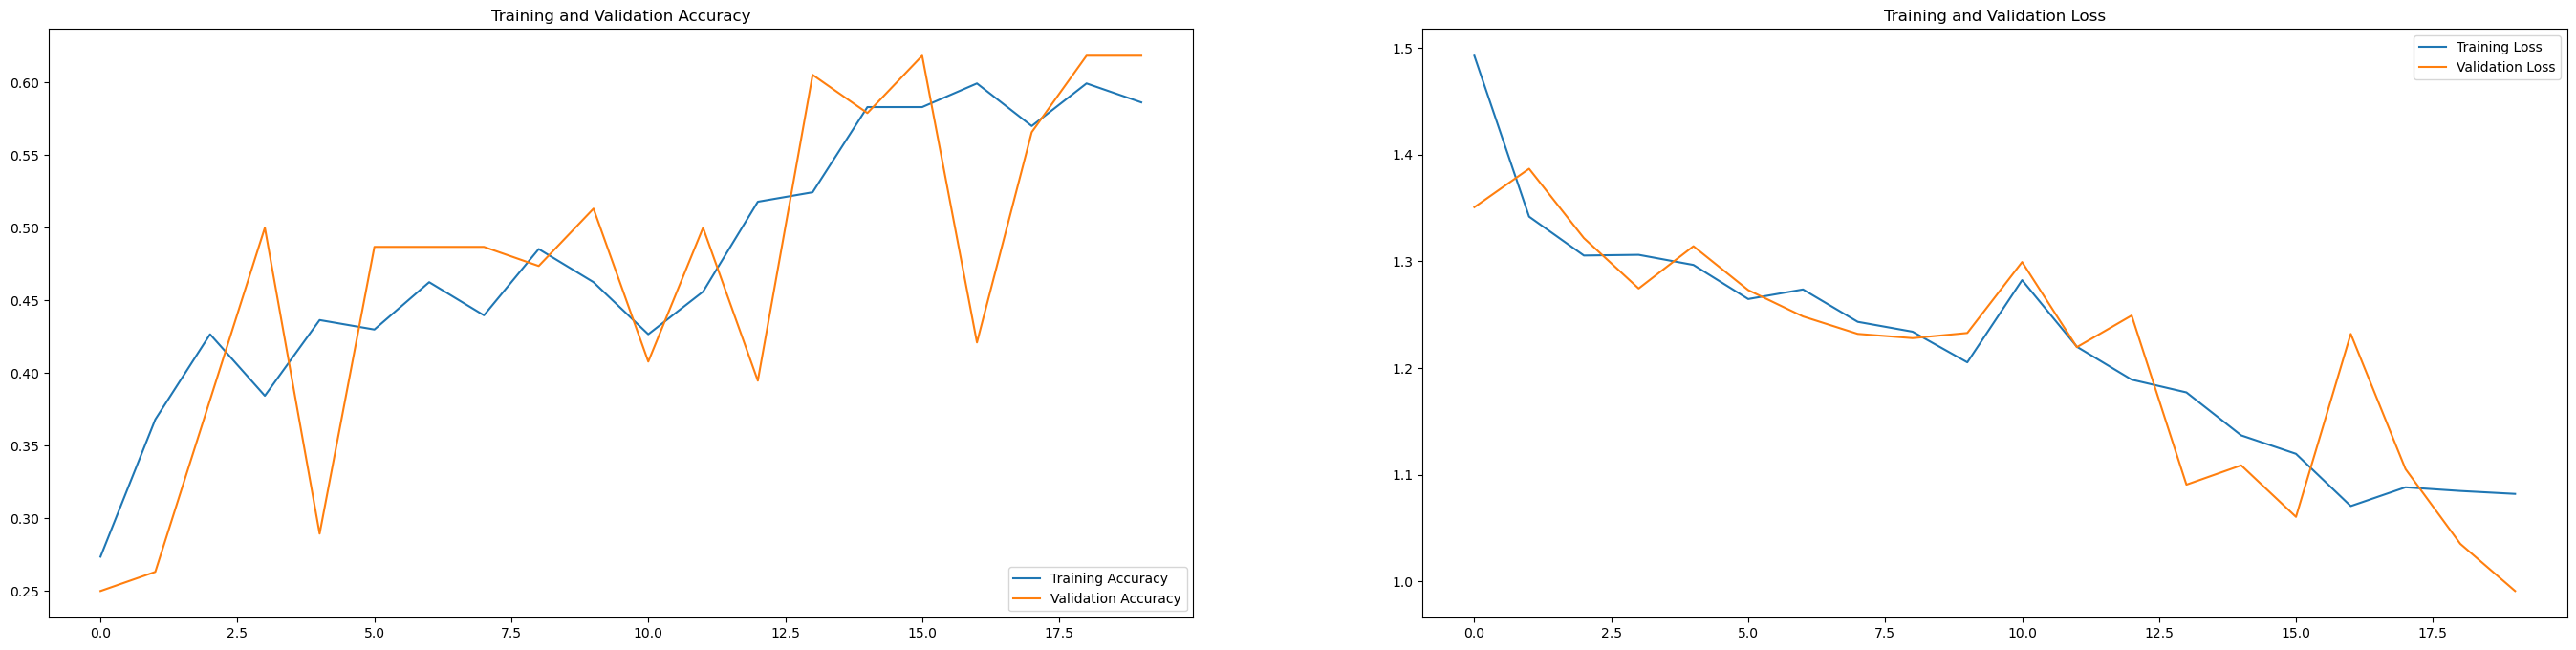

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(34, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('saved_models/tf_tensor/plt_fig/tl_fig'+ str(dt_save) + '_' +str(sc_model) + '.png')
plt.show()


In [82]:
# folder path to save figureplot 
sp_matrix = r'saved_models/tf_tensor/model'
sc_matrix = 0
# Iterate directory
for path in os.listdir(sp_matrix):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_matrix, path)):
        sc_matrix += 1
print('File count:', sc_matrix)

File count: 1


4/4 [==============================] - 2s 353ms/step


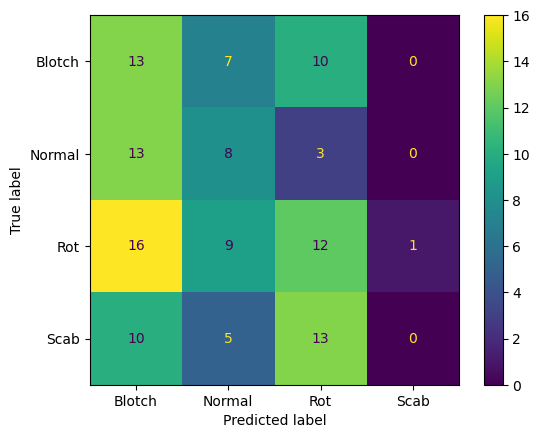

In [84]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
plt.savefig('saved_models/tf_tensor/plt_matrix/fig_matrix'+ str(dt_save) + '_' +str(sc_model) + '.png')
plt.show()


In [55]:
%tensorboard --logdir logs/



Reusing TensorBoard on port 6006 (pid 90554), started 2 days, 12:12:22 ago. (Use '!kill 90554' to kill it.)